In [1]:
import ROOT

Welcome to JupyROOT 6.24/06


In [17]:
ROOT.ROOT.EnableImplicitMT(16)

In [22]:
path = "/lustre/cms/store/user/adiflori/jpsikk_DataRunII_UltraLegacy_miniAODv2_v1_m4To6/Charmonium/crab_Charmonium_Run2018D-UL2018_MiniAODv2-v1_MINIAOD__1SKK_20220512_114449/220512_094551/0000/merged/file2*.root"

In [23]:
data = ROOT.RDataFrame("rootuple/CandidateTree", path)

In [24]:
cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")

hist1 = cut.Histo1D(("candidate_vMass", "candidate mass", 200, 5.25, 5.5), "candidate_vMass")

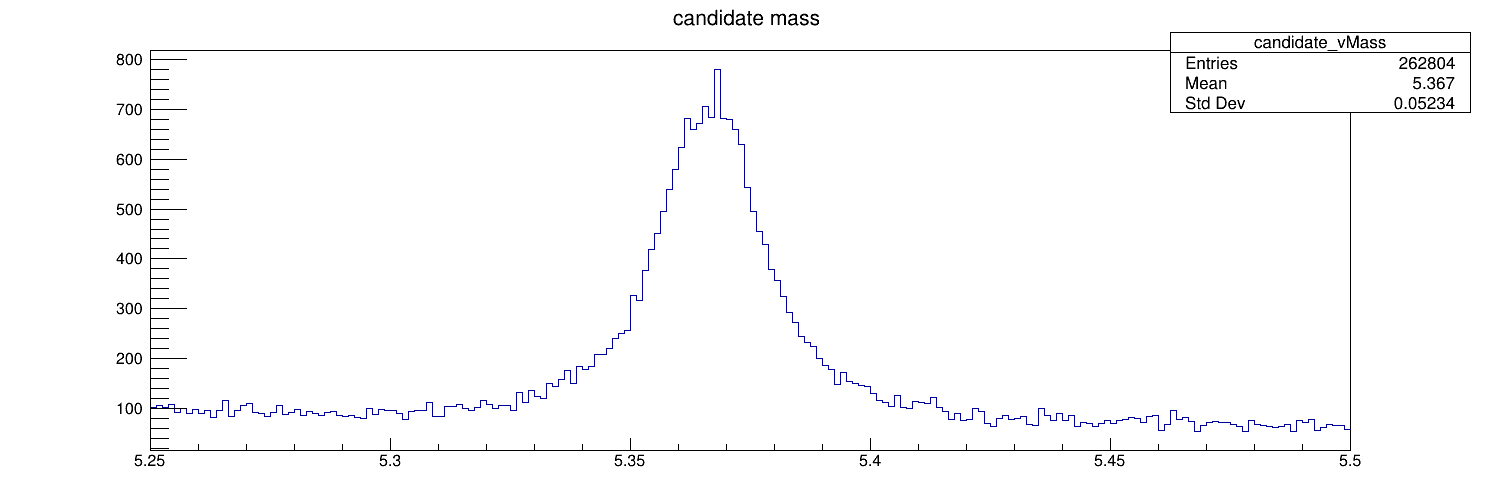

In [25]:
canvas1 = ROOT.TCanvas()
canvas1.SetCanvasSize(1500, 500)
hist1.Draw()
canvas1.Draw()

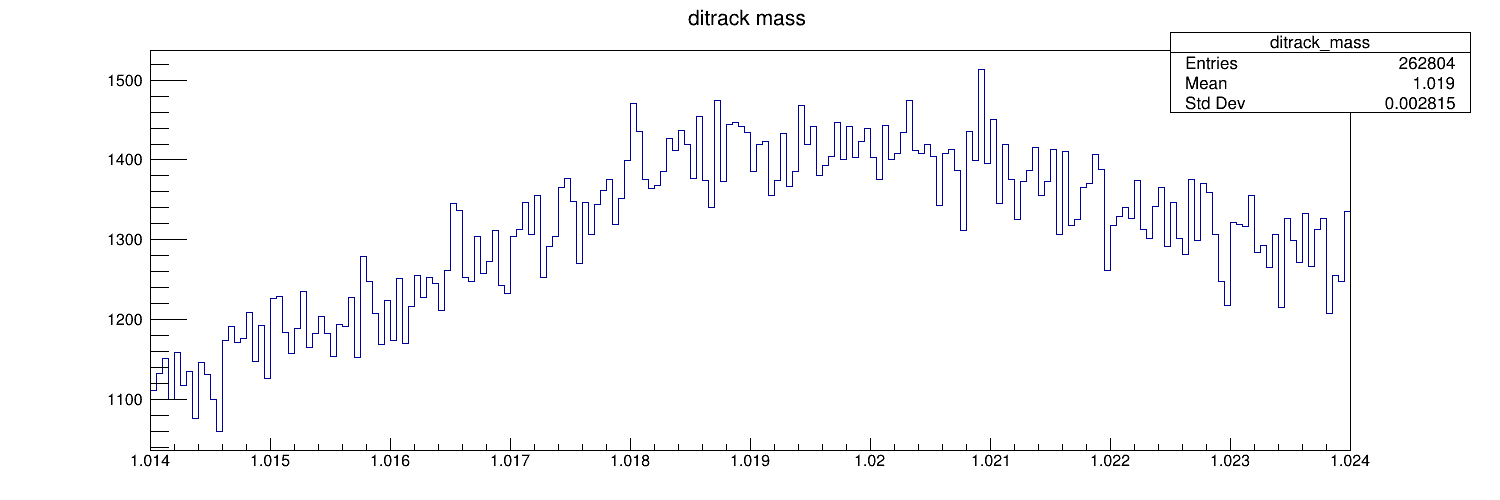

In [26]:
hist2 = cut.Histo1D(("ditrack_mass", "ditrack mass", 200, 1.014, 1.024), "ditrack_mass")
canvas2 = ROOT.TCanvas()
canvas2.SetCanvasSize(1500, 500)
hist2.Draw()
canvas2.Draw()

In [132]:
import ROOT
import os
import time
import matplotlib.pyplot as plt

In [133]:
path = "../merged/"


In [134]:
def performance_measure(path, num_files, num_threads):
    # Specify the number of threads
    ROOT.ROOT.EnableImplicitMT(num_threads)
    
    # Get paths to all the files to be read 
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    total_size = 0
    for i in range(num_files):
        files_to_read.push_back(path + filenames[i])
        total_size += os.path.getsize(path + filenames[i])
    
    # Measure runtime
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    array = cut.AsNumpy(["candidate_vMass"])
#     hist = cut.Histo1D(("candidate_vMass", "candidate mass", 200, 5.25, 5.5), "candidate_vMass")
#     canvas = ROOT.TCanvas()
#     canvas.SetCanvasSize(1500, 500)
#     hist.Draw()
#     canvas.Draw()
    run_time = time.time() - start_time
    
    return total_size / (2**30), run_time, array
    

In [114]:
performance_measure(path, 10, 16)

(20.26633054204285,
 16.220045566558838,
 {'candidate_vMass': ndarray([5.34885645, 5.37125015, 5.36299658, ..., 5.36462307, 5.36008072,
           5.35387468])})

In [152]:
def runtime_vs_size(path, num_threads, max_files, step):
    i = step
    x = []
    y = []
    while i <= max_files:
        size, runtime, _ = performance_measure(path, i, num_threads)
        x.append(size)
        y.append(runtime)
        i += step
    return x, y
    

In [153]:
def runtime_vs_threads(path, num_files, max_threads, step):
    i = step
    x = []
    y = []
    while i <= max_threads:
        size, runtime, _ = performance_measure(path, num_files, i)
        x.append(i)
        y.append(runtime)
        i += step
    return x, y, size
    

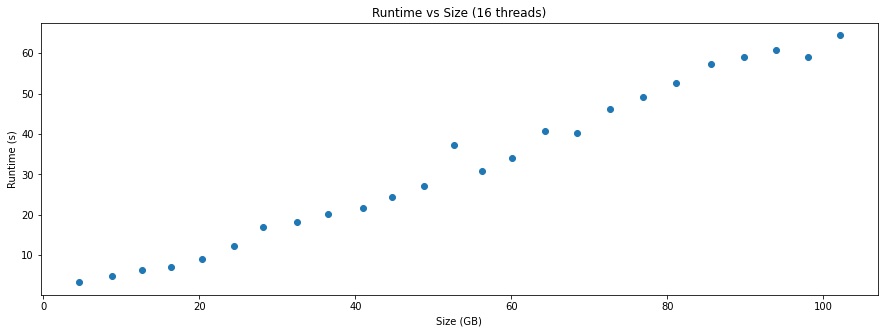

In [154]:
x, y = runtime_vs_size(path, 16, 50, 2)

plt.figure(figsize = (15, 5))
plt.title('Runtime vs Size (16 threads)')
plt.xlabel('Size (GB)')
plt.ylabel('Runtime (s)')
plt.scatter(x, y)
plt.savefig('figures/runtime_vs_size_16_50_2.png', bbox_inches='tight')

with open('figures/runtime_vs_size_16_50_2.txt', 'w') as f:
    f.write('Size: ')
    f.write(str(x) + '\n')
    f.write('Runtime: ')
    f.write(str(y))

In [ ]:
x, y, size = runtime_vs_threads(path, 20, 40, 4)

plt.figure(figsize = (15, 5))
plt.title('Runtime vs Threads (%.2f GB)' % (size))
plt.xlabel('Threads')
plt.ylabel('Runtime (s)')
plt.scatter(x, y)
plt.savefig('figures/runtime_vs_threads_20_40_4.png', bbox_inches='tight')

with open('figures/runtime_vs_threads_20_40_4.txt', 'w') as f:
    f.write('Threads: ')
    f.write(str(x) + '\n')
    f.write('Runtime: ')
    f.write(str(y))